In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
roc_curve, precision_recall_fscore_support)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import joblib
import json

sns.set(style='whitegrid')

RANDOM_STATE = 42

In [12]:
df = pd.read_csv('heart_disease_dataset.csv')
print('Shape:', df.shape)
df.head()

Shape: (400, 14)


,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,heart_disease
0,58,1,1,134,246,0,0,155,0,0.4,1,1,2,1
1,52,0,2,112,245,0,0,143,1,0.1,0,0,3,1
2,59,0,2,126,196,0,0,162,1,1.1,1,0,1,1
3,67,1,1,165,201,0,0,180,0,0.4,2,0,2,0
4,51,1,0,146,174,1,1,133,1,0.9,1,1,2,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      400 non-null    int64  
 1   sex                      400 non-null    int64  
 2   chest_pain_type          400 non-null    int64  
 3   resting_blood_pressure   400 non-null    int64  
 4   cholesterol              400 non-null    int64  
 5   fasting_blood_sugar      400 non-null    int64  
 6   resting_ecg              400 non-null    int64  
 7   max_heart_rate           400 non-null    int64  
 8   exercise_induced_angina  400 non-null    int64  
 9   st_depression            400 non-null    float64
 10  st_slope                 400 non-null    int64  
 11  num_major_vessels        400 non-null    int64  
 12  thalassemia              400 non-null    int64  
 13  heart_disease            400 non-null    int64  
dtypes: float64(1), int64(13)
m

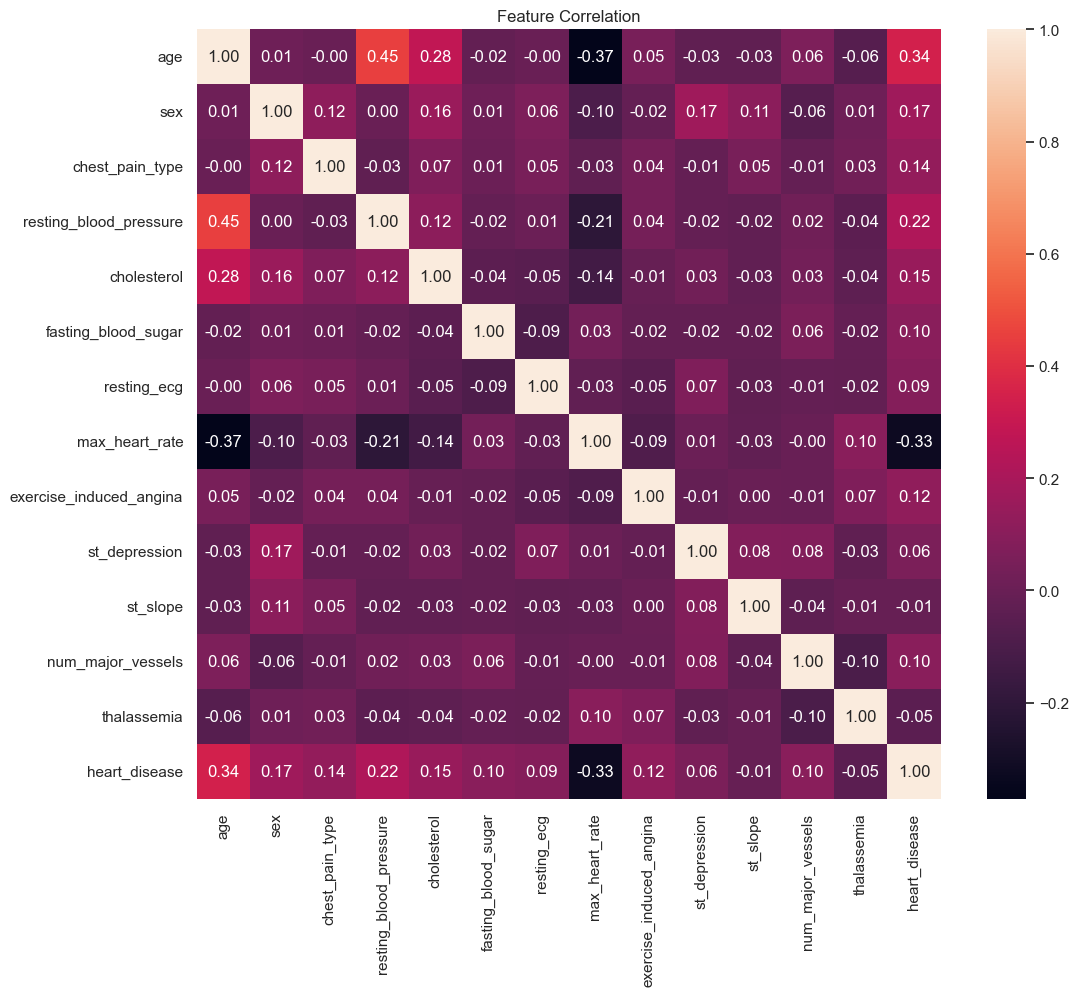

In [13]:
print(df.info())
print(df.describe())
print('Class distribution:\n', df['heart_disease'].value_counts(normalize=True))

# pairplot or correlation
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.title('Feature Correlation')
plt.show()

In [14]:
FEATURES = [c for c in df.columns if c != 'heart_disease']
TARGET = 'heart_disease'

X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)
print(X_train.shape, X_test.shape)

(320, 13) (80, 13)


In [15]:
pipelines = {
'logreg': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))]),
'svc': Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True, random_state=RANDOM_STATE))]),
'dt': Pipeline([('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))]),
'rf': Pipeline([('clf', RandomForestClassifier(random_state=RANDOM_STATE))])
}

grids = {
'logreg': {'clf__C': [0.01, 0.1, 1, 10]},
'svc': {'clf__C': [0.1, 1, 10], 'clf__kernel': ['rbf', 'linear']},
'dt': {'clf__max_depth': [3, 5, 7, None], 'clf__min_samples_split': [2, 5, 10]},
'rf': {'clf__n_estimators': [50, 100, 200], 'clf__max_depth': [None, 5, 10]}
}

In [16]:
results = {}

for name, pipe in pipelines.items():
    print(f'\nTraining {name}...')
    grid = GridSearchCV(pipe, grids[name], cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    y_pred = best.predict(X_test)
    y_proba = best.predict_proba(X_test)[:,1] if hasattr(best, 'predict_proba') else best.decision_function(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'best_params': grid.best_params_,
        'estimator': best,
        'classification_report': report,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }
    print(name, 'best params:', grid.best_params_)
    print('ROC AUC:', roc_auc)
    print(classification_report(y_test, y_pred))


Training logreg...
logreg best params: {'clf__C': 0.01}
ROC AUC: 0.7386363636363636
              precision    recall  f1-score   support

           0       0.67      0.44      0.53        36
           1       0.64      0.82      0.72        44

    accuracy                           0.65        80
   macro avg       0.65      0.63      0.63        80
weighted avg       0.65      0.65      0.64        80


Training svc...
svc best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
ROC AUC: 0.750631313131313
              precision    recall  f1-score   support

           0       0.63      0.61      0.62        36
           1       0.69      0.70      0.70        44

    accuracy                           0.66        80
   macro avg       0.66      0.66      0.66        80
weighted avg       0.66      0.66      0.66        80


Training dt...
dt best params: {'clf__max_depth': 3, 'clf__min_samples_split': 2}
ROC AUC: 0.6682449494949495
              precision    recall  f1-score   su

In [17]:
summary = []
for name, res in results.items():
    f1 = res['classification_report']['1']['f1-score']
    roc = res['roc_auc']
    summary.append((name, f1, roc))

summary_df = pd.DataFrame(summary, columns=['model','f1','roc_auc']).sort_values(by='f1', ascending=False)
summary_df

,model,f1,roc_auc
2,dt,0.730769,0.668245
3,rf,0.721649,0.768939
0,logreg,0.720000,0.738636
1,svc,0.696629,0.750631


In [ ]:
best_model_name = summary_df.iloc[0]['model']
best_model = results[best_model_name]['estimator']

joblib.dump(best_model, 'best_model.pkl')
print('Saved best model:', best_model_name)

# Save feature order (important for deployment)
with open('feature_order.json', 'w') as f:
    json.dump(FEATURES, f)
print('Saved feature_order.json')

Saved best model: dt
Saved feature_order.json


In [19]:
X_test.iloc[:5].to_csv('sample_inputs.csv', index=False)
print('Saved sample_inputs.csv')

Saved sample_inputs.csv
